In [ ]:
  pip install structure-tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for structure-tensor: filename=structure_tensor-0.2.0-py3-none-any.whl size=15924 sha256=d8e881b4a2904e05f2bcd295b4d6d460a0174cc11a63e4a1f4b6ce8588de2df8
  Stored in directory: /root/.cache/pip/wheels/91/20/c3/7f70390148b5bd4ca9efcdd82ba1c678e7d26194a1c4d9401d
Successfully built structure-tensor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import random
import skimage.io
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
import os


os.chdir('/content/drive/MyDrive/NyDLProjekt')

from structure_tensor import eig_special_3d, structure_tensor_3d



# Load Data #

In [ ]:
def CreateDataLoaders(split_ratios = [0.9,0.1],batch_size = 4,single = False):
    '''
    Loads saved the saved dataset, and returns dataloaders for the train, test
    and validation sets. Takes the parameter split_ratios for the data split,
    and batch_size to control batch size
    
    '''
    
    if sum(split_ratios) != 1:
        print("Sum of split_ratios must be 1!")
        raise ValueError
    
    X = np.load('rockwool_1_X.npy')
    Y = np.load('rockwool_1_Y.npy')
    
    #X = np.concatenate((X,X_2),axis = 0)  
    #Y = np.concatenate((Y,Y_2),axis = 0)
    nTraining,_,_,_ = X.shape
    tensor_y = torch.Tensor(Y)
    tensor_x = torch.Tensor(X)

    #tensor_precomp = torch.Tensor(precomp)
    my_dataset = TensorDataset(tensor_x,tensor_y)
    if single == True:
        return DataLoader(my_dataset, batch_size)
    
    # the data splitter needs lengths not ratios so we convert 
    lengths = [int(nTraining*split_ratios[i]) for i in range(2)]
    lengths[0] += nTraining - sum(lengths) 
    
    
    train,val = torch.utils.data.random_split(my_dataset,lengths,generator=torch.Generator().manual_seed(42))
    train = DataLoader(train, batch_size,shuffle = True)
    val = DataLoader(val, batch_size,shuffle = True)
    return train, val
scale = 0.5
height = width = depth = 50
batch_size = 16
trainloader,valloader = CreateDataLoaders(batch_size = batch_size)

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

1
Tesla T4


Simple test of GPU training

In [ ]:

from sympy import *
import numpy as np
from numpy import arctan2, sqrt
import numexpr as ne


def cords2angles(y):
    batch_size,c,height,width,depth = y.shape
    theta = torch.empty([batch_size,2,height,width,depth])
    theta = theta.cuda()
    theta[:,0,:,:,:] = torch.arctan2(y[:,1,:,:,:], y[:,0,:,:,:])
    theta[:,1,:,:,:] = torch.arctan2(torch.sqrt(y[:,0,:,:,:]**2+y[:,1,:,:,:]**2), y[:,2,:,:,:])
    return theta

def angles2cords(theta):
    batch_size,c,height,width,depth = theta.shape
    ynew = torch.empty([batch_size,3,height,width,depth])
    ynew = ynew.cuda()
    ynew[:,0,:,:,:] = torch.cos(theta[:,0,:,:,:]) * torch.sin(theta[:,1,:,:,:])#x
    ynew[:,1,:,:,:] = torch.sin(theta[:,1,:,:,:]) * torch.sin(theta[:,0,:,:,:]) #y
    ynew[:,2,:,:,:] = torch.cos(theta[:,1,:,:,:]) #z
    return ynew

def anglediff(y,y1):
    delta = 2*(1-torch.cos(y1*2-y*2))
    return torch.mean(delta)
    

In [ ]:
from numpy.lib.arraysetops import in1d



class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__() 
        self.out1 = 6*2
        self.out2 = 12*2
        self.out3 = 24*2
        self.out4 = 48*2
        self.out5 = 96*2


        self.kernel_size = 3
        self.padding = 1


        #StructureTensorPart
        self.up = nn.Upsample(scale_factor = 2, mode = 'trilinear',align_corners=True)
        self.down = nn.Upsample(scale_factor = 1/2,mode = 'trilinear',align_corners=True)
        self.down2 = nn.Upsample(scale_factor = 24/25,mode = 'trilinear',align_corners=True)
        self.S_conv1 = nn.Conv3d(in_channels = 2, out_channels = self.out1, kernel_size = self.kernel_size, padding = 0 )
        self.S_conv2 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)
        self.S_mp1 = nn.MaxPool3d(kernel_size = 2)
        self.S_bn1 = nn.BatchNorm3d(self.out1)
        self.S_conv3 = nn.Conv3d(in_channels = self.out1, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.S_conv4 = nn.Conv3d(in_channels = self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.S_mp2 = nn.MaxPool3d(kernel_size = 2)
        self.S_bn2 = nn.BatchNorm3d(self.out2)
        self.S_conv5 = nn.Conv3d(in_channels = self.out2, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.S_conv6 = nn.Conv3d(in_channels = self.out3, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.S_mp3 = nn.MaxPool3d(kernel_size = 2)
        self.S_bn3 = nn.BatchNorm3d(self.out3)
        self.S_conv7 = nn.Conv3d(in_channels = self.out3, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.S_conv8 = nn.Conv3d(in_channels = self.out4, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.S_mp4 = nn.MaxPool3d(kernel_size = 2)
        self.S_bn4 = nn.BatchNorm3d(self.out4)
        self.S_conv9 = nn.Conv3d(in_channels = self.out4, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        self.S_conv10 = nn.Conv3d(in_channels = self.out5, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        


        #FullImagePart
        self.I_conv1 = nn.Conv3d(in_channels = 1, out_channels = self.out1, kernel_size = self.kernel_size, padding = 0 )
        self.I_conv2 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)
        self.I_mp1 = nn.MaxPool3d(kernel_size = 2)
        self.I_bn1 = nn.BatchNorm3d(self.out1)
        self.I_conv3 = nn.Conv3d(in_channels = self.out1, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.I_conv4 = nn.Conv3d(in_channels = self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.I_mp2 = nn.MaxPool3d(kernel_size = 2)
        self.I_bn2 = nn.BatchNorm3d(self.out2)
        self.I_conv5 = nn.Conv3d(in_channels = self.out2, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.I_conv6 = nn.Conv3d(in_channels = self.out3, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.I_mp3 = nn.MaxPool3d(kernel_size = 2)
        self.I_bn3 = nn.BatchNorm3d(self.out3)
        self.I_conv7 = nn.Conv3d(in_channels = self.out3, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.I_conv8 = nn.Conv3d(in_channels = self.out4, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.I_mp4 = nn.MaxPool3d(kernel_size = 2)
        self.I_bn4 = nn.BatchNorm3d(self.out4)
        self.I_conv9 = nn.Conv3d(in_channels = self.out4, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        self.I_conv10 = nn.Conv3d(in_channels = self.out5, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        



        #Combining part

        self.convST1 = nn.ConvTranspose3d(in_channels = self.out5, out_channels = self.out4,kernel_size = 2, stride = 2)
        self.convIT1 = nn.ConvTranspose3d(in_channels = self.out5, out_channels = self.out4,kernel_size = 2, stride = 2)

        self.conv7 = nn.Conv3d(in_channels = 4*self.out4, out_channels = self.out4, kernel_size =self.kernel_size, padding = self.padding)
        self.conv8 = nn.Conv3d(in_channels = self.out4, out_channels = self.out4, kernel_size =self.kernel_size, padding = self.padding)
        
        self.convT2 = nn.ConvTranspose3d(in_channels = self.out4, out_channels = self.out3,kernel_size = 2,stride = 2)


        self.conv9 = nn.Conv3d(in_channels = 3 * self.out3, out_channels = self.out3, kernel_size =self.kernel_size, padding = self.padding)
        self.conv10 = nn.Conv3d(in_channels = self.out3, out_channels = self.out3, kernel_size =self.kernel_size, padding = self.padding)
        
        self.convT3 = nn.ConvTranspose3d(in_channels = self.out3, out_channels = self.out2, kernel_size = 2, stride = 2)
        
        self.conv11 = nn.Conv3d(in_channels = 3 * self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.conv12 = nn.Conv3d(in_channels = self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        
        self.convT4 = nn.ConvTranspose3d(in_channels = self.out2, out_channels = self.out1,kernel_size = 2,stride = 2)
        self.convT5 = nn.ConvTranspose3d(in_channels = 3*self.out1, out_channels = self.out1, kernel_size =self.kernel_size, stride = 1, padding = 0)
        
        self.conv13 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)
        self.conv14 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)

        self.conv15 = nn.Conv3d(in_channels = self.out1, out_channels = 2, kernel_size =self.kernel_size, padding = self.padding)


    def st_vec(self, x, scale):
      X = torch.zeros([batch_size,3,int(height*scale),int(width*scale),int(depth*scale)])
      X.cuda()
      for b in range(batch_size):
          s = structure_tensor_3d(x[b,0,:,:,:],1/2,1)
          val,vec = eig_special_3d(s)
          X[b,:,:,:,:] = torch.Tensor(vec)
      return X



    def forward(self, x):
       xstruct = self.down(x)
       s2 = self.st_vec(xstruct, scale)
       s1 = self.up(s2)
       s1 = cords2angles(s1)
       x = x.cuda()
      
       i1 = F.relu(self.I_conv1(x))
       s1 = F.relu(self.S_conv1(s1))
       i1 = F.relu(self.I_conv2(i1))
       s1 = F.relu(self.S_conv2(s1))
       i2 = self.I_bn1(i1)
       s2 = self.S_bn1(s1)
       i2 = self.I_mp1(i2)
       s2 = self.S_mp1(s2)


       i2 = F.relu(self.I_conv3(i2))
       s2 = F.relu(self.S_conv3(s2))
       i2 = F.relu(self.I_conv4(i2))
       s2 = F.relu(self.S_conv4(s2))
       i3 = self.I_bn2(i2)
       s3 = self.S_bn2(s2)
       i3 = self.I_mp2(i3)
       s3 = self.S_mp2(s3)

       i3 = F.relu(self.I_conv5(s3))
       s3 = F.relu(self.S_conv5(s3))
       i3 = F.relu(self.I_conv6(i3))
       s3 = F.relu(self.S_conv6(s3))
       i4 = self.I_bn3(i3)
       s4 = self.S_bn3(s3)
       i4 = self.I_mp3(i4)
       s4 = self.S_mp3(s4)

       i4 = F.relu(self.I_conv7(i4))
       s4 = F.relu(self.S_conv7(s4))
       i4 = F.relu(self.I_conv8(i4))
       s4 = F.relu(self.S_conv8(s4))
       i5 = self.I_bn4(i4)
       s5 = self.S_bn4(s4)
       i5 = self.I_mp4(i5)
       s5 = self.S_mp4(s5)

       
       i5 = F.relu(self.I_conv9(i5))
       s5 = F.relu(self.S_conv9(s5))
       i5 = F.relu(self.I_conv10(i5))
       s5 = F.relu(self.S_conv10(s5))

       

       uI4 = self.convIT1(i5)
       uS4 = self.convST1(s5)



       u4 = torch.cat((uI4,uS4, i4, s4),dim = 1)
       u4 = F.relu(self.conv7(u4))
       u4 = F.relu(self.conv8(u4))
       u3 = self.convT2(i4)
       u3 = torch.cat((u3,i3, s3),dim = 1)
       u3 = F.relu(self.conv9(u3))
       u3 = F.relu(self.conv10(u3))
       u2 = self.convT3(u3)
       u2 = torch.cat((u2,s2,i2),dim = 1)
       u2 = F.relu(self.conv11(u2))
       u2 = F.relu(self.conv12(u2))
       u1 = self.convT4(u2)
       u1 = torch.cat((u1,s1,i1), dim= 1)
       u1 = self.convT5(u1)
       u1 = F.relu(self.conv13(u1))
       u1 = F.relu(self.conv14(u1))
       u1 = torch.tanh(self.conv15(u1))*torch.pi

       #u1 = F.normalize(self.conv11(u1),dim = 1)
       return u1  
    

100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch 1 		 Training Loss: 1.1869972091296623


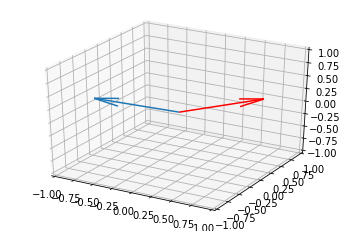

Validation loss:  0.9366920164653233


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 2 		 Training Loss: 0.8772856521195379


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 3 		 Training Loss: 0.8346499821235394


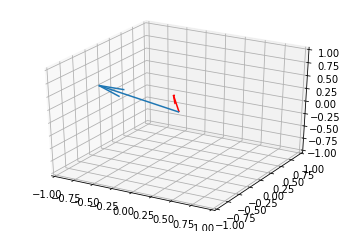

Validation loss:  0.8241387690816607


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 4 		 Training Loss: 0.8095547556877136


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 5 		 Training Loss: 0.7690913779982205


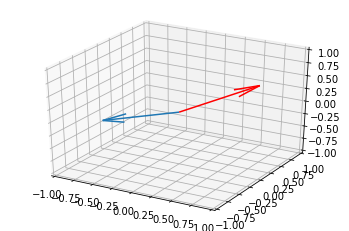

Validation loss:  0.7751412561961583


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 6 		 Training Loss: 0.7579155132688326


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 7 		 Training Loss: 0.745547336751017


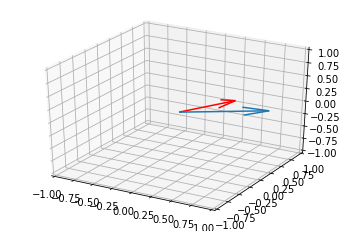

Validation loss:  0.7553815075329372


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 8 		 Training Loss: 0.737439346724543


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 9 		 Training Loss: 0.7242489015233928


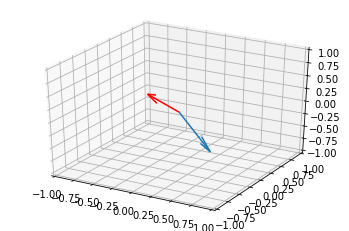

Validation loss:  0.737708968775613


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 10 		 Training Loss: 0.7195168918576734


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 11 		 Training Loss: 0.7072351616004418


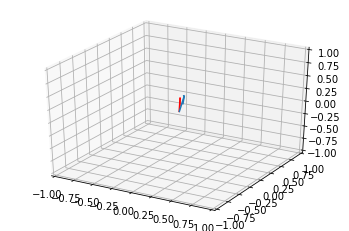

Validation loss:  0.7419384377343314


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 12 		 Training Loss: 0.6925214981210643


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 13 		 Training Loss: 0.6875895446744459


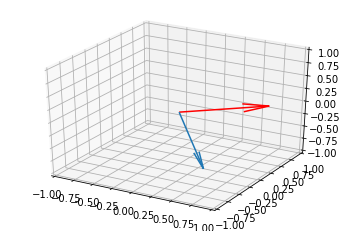

Validation loss:  0.7071720617158073


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 14 		 Training Loss: 0.6733578556570513


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 15 		 Training Loss: 0.6554013028227049


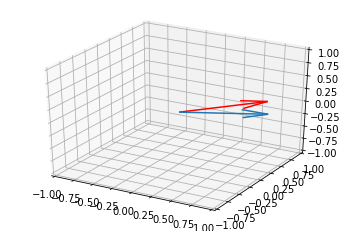

Validation loss:  0.7018549527440753


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 16 		 Training Loss: 0.6380620732389647


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 17 		 Training Loss: 0.6295355722821993


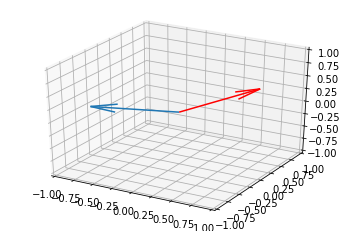

Validation loss:  0.6547018800462995


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 18 		 Training Loss: 0.6112960453691154


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 19 		 Training Loss: 0.6021506210853314


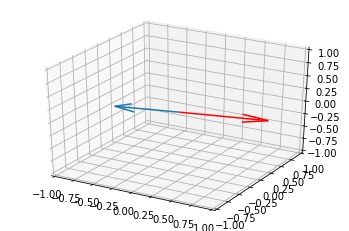

Validation loss:  0.6073748384203229


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 20 		 Training Loss: 0.5958727228230444


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 21 		 Training Loss: 0.5836191537051365


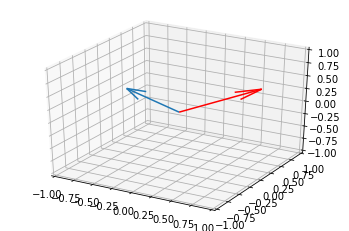

Validation loss:  0.6057680930410113


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 22 		 Training Loss: 0.5821473978716751


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 23 		 Training Loss: 0.570824736151202


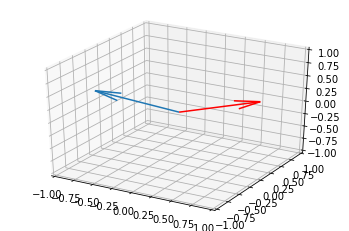

Validation loss:  0.5837643487112862


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 24 		 Training Loss: 0.569607216736366


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 25 		 Training Loss: 0.5591678084998295


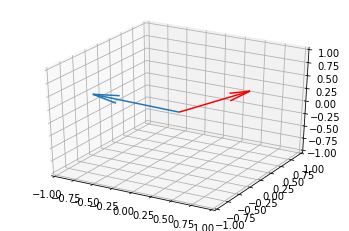

Validation loss:  0.6279205594744001


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 26 		 Training Loss: 0.5610562696539122


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 27 		 Training Loss: 0.5555310917311701


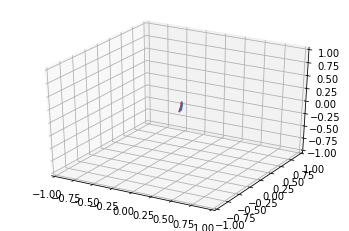

Validation loss:  0.5954553144318717


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 28 		 Training Loss: 0.551775361443388


100%|██████████| 58/58 [00:44<00:00,  1.31it/s]


Epoch 29 		 Training Loss: 0.5437309264109053


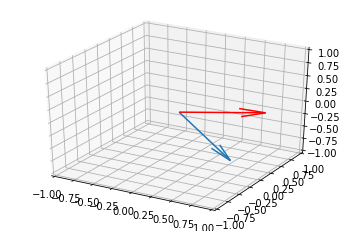

Validation loss:  0.5467706833566938


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 30 		 Training Loss: 0.542695200134968


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 31 		 Training Loss: 0.5425324388619127


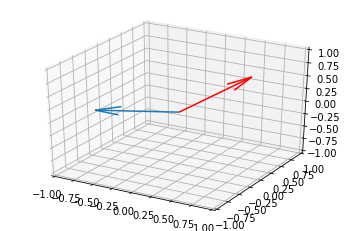

Validation loss:  0.5391968233244759


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 32 		 Training Loss: 0.5398315103917286


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 33 		 Training Loss: 0.5322184804184683


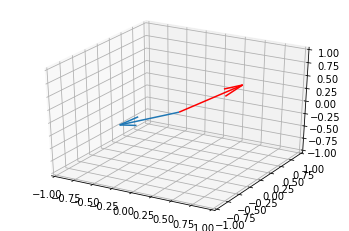

Validation loss:  0.559695133141109


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 34 		 Training Loss: 0.5316557139158249


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 35 		 Training Loss: 0.5218464567743498


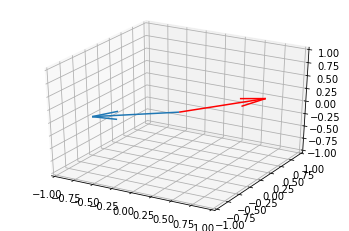

Validation loss:  0.5338926911354065


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 36 		 Training Loss: 0.52535146269305


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 37 		 Training Loss: 0.5208154264195212


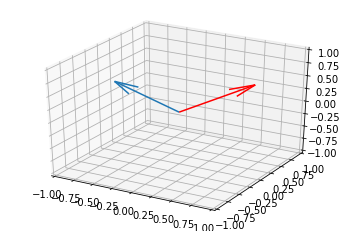

Validation loss:  0.5805642349379403


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 38 		 Training Loss: 0.5237009859290617


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 39 		 Training Loss: 0.5139775897922187


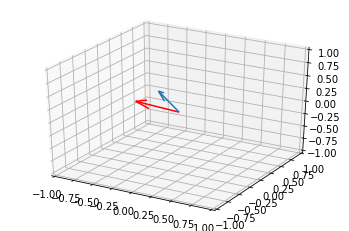

Validation loss:  0.5742487141064235


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 40 		 Training Loss: 0.5151203963263281


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 41 		 Training Loss: 0.5094059217592766


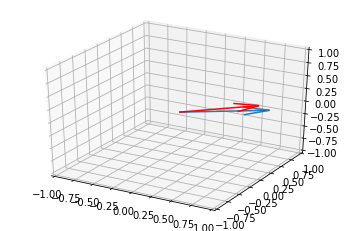

Validation loss:  0.5475007125309536


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 42 		 Training Loss: 0.5073968357053297


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 43 		 Training Loss: 0.5026238478463272


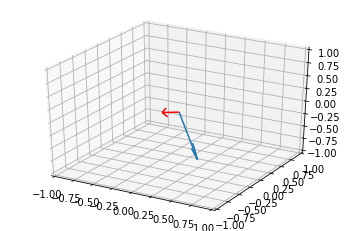

Validation loss:  0.5116664980139051


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 44 		 Training Loss: 0.4979905213775306


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 45 		 Training Loss: 0.5048123962920288


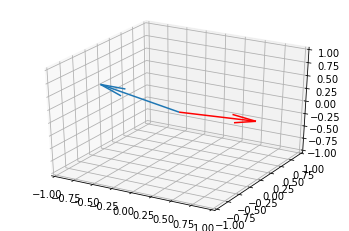

Validation loss:  0.5200726773057666


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 46 		 Training Loss: 0.5004717342812439


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 47 		 Training Loss: 0.4972207808289035


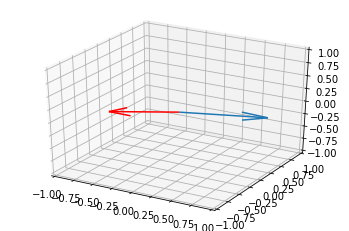

Validation loss:  0.5498059902872358


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 48 		 Training Loss: 0.4951319196100893


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 49 		 Training Loss: 0.4903796885547967


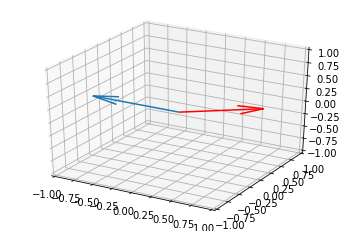

Validation loss:  0.5385283316884723


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 50 		 Training Loss: 0.4958694299747204


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 51 		 Training Loss: 0.4934729240063963


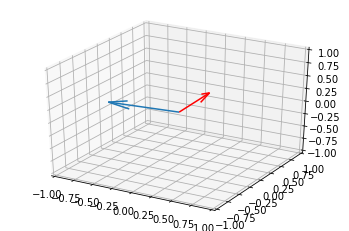

Validation loss:  0.497037159545081


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 52 		 Training Loss: 0.4895773314196488


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 53 		 Training Loss: 0.49529069764860745


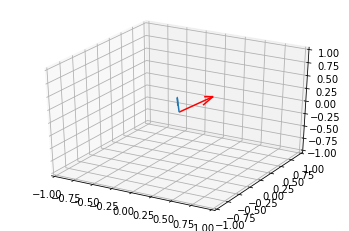

Validation loss:  0.508717634848186


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 54 		 Training Loss: 0.4855181513161495


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 55 		 Training Loss: 0.4845638146688198


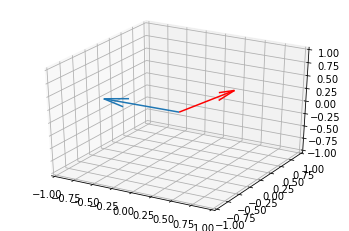

Validation loss:  0.5233968964644841


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 56 		 Training Loss: 0.47748655389095174


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 57 		 Training Loss: 0.47979153024739235


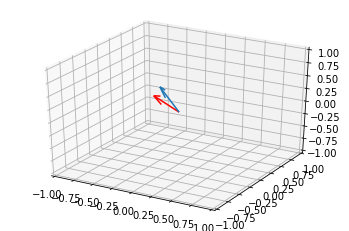

Validation loss:  0.5012274384498596


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 58 		 Training Loss: 0.48333408144013634


100%|██████████| 58/58 [00:44<00:00,  1.30it/s]


Epoch 59 		 Training Loss: 0.4750584466704007


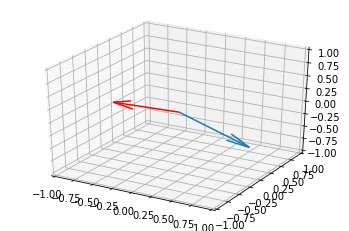

Validation loss:  0.5208744278975895


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 60 		 Training Loss: 0.4771959761093403


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 61 		 Training Loss: 0.480097944880354


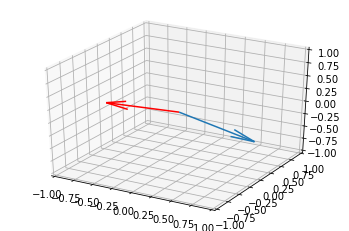

Validation loss:  0.5445618970053536


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 62 		 Training Loss: 0.47873431958001234


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 63 		 Training Loss: 0.4728877739659671


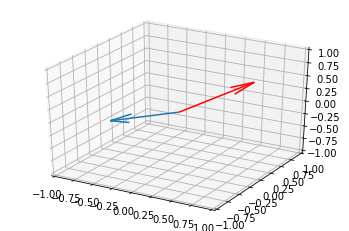

Validation loss:  0.49645144598824636


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 64 		 Training Loss: 0.472056884703965


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 65 		 Training Loss: 0.47400697757457866


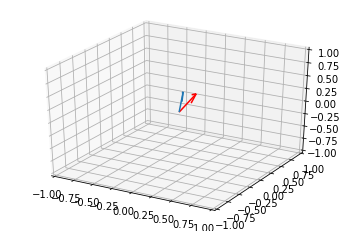

Validation loss:  0.4903870565550668


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 66 		 Training Loss: 0.46715615535604543


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 67 		 Training Loss: 0.46959066339607897


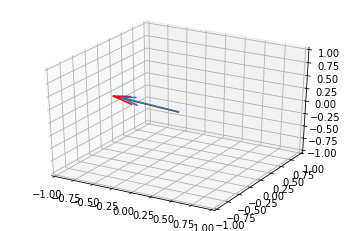

Validation loss:  0.4781020624297006


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 68 		 Training Loss: 0.4643804544004901


100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


Epoch 69 		 Training Loss: 0.4630011633552354


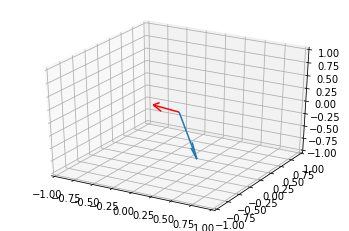

Validation loss:  0.47642659715243746


100%|██████████| 58/58 [00:45<00:00,  1.27it/s]


Epoch 70 		 Training Loss: 0.46565454478921564


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 71 		 Training Loss: 0.4702580925719491


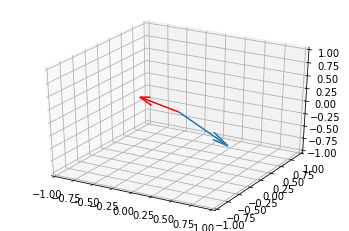

Validation loss:  0.4661231211253575


100%|██████████| 58/58 [00:45<00:00,  1.29it/s]


Epoch 72 		 Training Loss: 0.46291105654732934


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 73 		 Training Loss: 0.4630962795224683


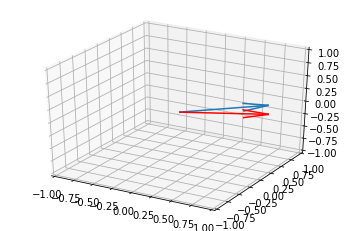

Validation loss:  0.4560855116162981


100%|██████████| 58/58 [00:45<00:00,  1.28it/s]


Epoch 74 		 Training Loss: 0.4613411030892668


 10%|█         | 6/58 [00:05<00:47,  1.10it/s]


KeyboardInterrupt: ignored

In [ ]:
net = Net_2()
net.train()
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 100
eval_every = 2


val_losslist = []
for e in range(epochs):
    train_loss = 0.0
    net.train()
    for Data in tqdm(trainloader):
        #Training 
        x_train,y_train = Data
        y_train = cords2angles(y_train)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        batch_size,_,_,_ = x_train.shape
        y_pred = net(x_train.reshape([batch_size,1,height,width,depth]))
        # Find the Loss
        loss = anglediff(y_train,y_pred)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        
        #print(train_loss)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)}')
    if e % eval_every == 0:
      validation_loss = 0
      net.eval()
      for j, Data in enumerate(valloader):
                x_val,y_val = Data
                #y_val_chords = cords2angles(y_val)
                y_val_angle = cords2angles(y_val)
                batch_size,_,_,_ = x_val.shape
                yval_pred = net(x_val.reshape([batch_size,1,height,width,depth]))
                v_loss= anglediff(y_val_angle,yval_pred).item()
                validation_loss += v_loss
                val_losslist.append(v_loss)
                yval_pred = angles2cords(yval_pred)

                if j == len(valloader)-1: # last validation batch:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    xr = random.randint(10,40)
                    yr = random.randint(10,40)
                    zr = random.randint(10,40)
                    ax.quiver(0,0,0,yval_pred[0,0,xr,yr,zr].item(),yval_pred[0,1,xr,yr,zr].item(),yval_pred[0,2,xr,yr,zr].item(),color = 'r')
                    ax.quiver(0,0,0,y_val[0,0,xr,yr,zr].item(),y_val[0,1,xr,yr,zr].item(),y_val[0,2,xr,yr,zr].item())
                    ax.set_xlim([-1, 1])
                    ax.set_ylim([-1, 1])
                    ax.set_zlim([-1, 1])
                    plt.show()
                    
                    print("Validation loss: ",validation_loss / len(valloader))

# Precalculated Structure Tensors# 

1.   List item
2.   List item



In [ ]:
# Eval loss as coordinate wise MSE
def MSENorm(y, y1):
  mean1 = torch.mean((y-y1)**2, 1)
  mean2 = torch.mean((y-(y1*(-1)))**2, 1)
  return torch.mean(torch.where(mean1>mean2,mean2,mean1))
Coordinate_MSE = 0
for Data in tqdm(valloader):
        net.eval()
        x_train,y_train = Data
        y_train = y_train.cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        batch_size,_,_,_ = x_train.shape
        y_pred = net(x_train.reshape([batch_size,1,height,width,depth]))
        # Find the Loss
        y_pred = angles2cords(y_pred)
        loss = MSENorm(y_train,y_pred)
        # Calculate gradients 
        
        # Calculate Loss
        Coordinate_MSE += loss.item()
        
        
print(Coordinate_MSE/len(trainloader))

100%|██████████| 58/58 [00:22<00:00,  2.64it/s]

0.1469527344251501


In [ ]:
# Save model
torch.save(net.state_dict(), 'polarTRAINED_new2.pt')

In [ ]:
model = Net_2()
model.load_state_dict(torch.load('polarTRAINED.pt'))
model.eval()

In [ ]:
print(model)